In [16]:
import urllib
import csv
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import concat
from pandas import DataFrame
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from mintpy.utils import readfile
# import pysar._readfile as readfile
from matplotlib.colors import LinearSegmentedColormap, LightSource
# import pysar.subset as subset
#import pysar.view as view
from mintpy import view
import scipy.io as sio
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib import cm
top = cm.get_cmap('jet', 128)

In [12]:
import time
from datetime import datetime as dt
data_dir= "~/onedrive/scratch/MaunaLoa/try/data/"
data_dir= "./data/"
filename = data_dir +'MKEA.txt'
!ls -l {filename}

def read_MKEA_data(time1,time2):
    filename = data_dir +'MKEA.txt'
    dfin = read_csv(filename, header=0, delimiter=r"\s+")
    index = ['Time', 'East', 'North', 'Up']
    dataval=DataFrame(index=index);dataerr=DataFrame(index=index);
    dataval=concat([dfin['YYMMMDD'].rename('date'), (dfin['_e0(m)']+dfin['__east(m)']).rename('east'), (dfin['____n0(m)']+dfin['_north(m)']).rename('north'), 
                    (dfin['u0(m)']+dfin['____up(m)']).rename('up'),dfin['yyyy.yyyy'].rename('dateval')], axis=1)
    dataerr=concat([dfin['YYMMMDD'].rename('date'), dfin['sig_e(m)'], dfin['sig_n(m)'], dfin['sig_u(m)']], axis=1,ignore_index=False)
    dataval['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    dataerr['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    mask= (dataval['date'] > time1) & (dataval['date'] < time2)
    dataval=dataval[mask];dataerr=dataerr[mask];
    dataval['up']=(dataval['up']-dataval['up'].iloc[0:30].mean())*1000;
    dataval['east']=(dataval['east']-dataval['east'].iloc[0:30].mean())*1000;
    dataval['north']=(dataval['north']-dataval['north'].iloc[0:30].mean())*1000;
    dataval=dataval.set_index(['date'])
    dataval=dataval.resample('D').interpolate(method='linear')
    dataval=dataval.reset_index()
    return dataval

def read_data(sitename,time1,time2):
    filename='/Users/bkv3/Documents/bkv3/Kilauea/GPS_kilauea/GPS_Maunaloa_2023/'+sitename+'.txt'
    dfin = read_csv(filename, header=0, delimiter=r"\s+")
    dfin = read_csv(filename, header=0, delimiter=r"\s+")
    index = ['Time', 'East', 'North', 'Up']
    dataval=DataFrame(index=index);dataerr=DataFrame(index=index);
    dataval=concat([dfin['YYMMMDD'].rename('date'), (dfin['_e0(m)']+dfin['__east(m)']).rename('east'), (dfin['____n0(m)']+dfin['_north(m)']).rename('north'), 
                    (dfin['u0(m)']+dfin['____up(m)']).rename('up'),dfin['yyyy.yyyy'].rename('dateval')], axis=1)
    dataerr=concat([dfin['YYMMMDD'].rename('date'), dfin['sig_e(m)'], dfin['sig_n(m)'], dfin['sig_u(m)']], axis=1,ignore_index=False)
    dataval['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    dataerr['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    #time1=2013;time2=2017;
    mask= (dataval['date'] > time1) & (dataval['date'] < time2)
    dataval=dataval[mask];dataerr=dataerr[mask];
    dataval['up']=(dataval['up']-dataval['up'].iloc[0:30].mean())*1000;
    dataval['east']=(dataval['east']-dataval['east'].iloc[0:30].mean())*1000;
    dataval['north']=(dataval['north']-dataval['north'].iloc[0:30].mean())*1000;
    dataval=dataval.set_index(['date'])
    dataval=dataval.resample('D').interpolate(method='linear');
    dataval=dataval.reset_index();
    dataval2=read_MKEA_data(time1,time2)
    merged=pd.merge(dataval,dataval2,how='inner',on=['date'])
    merged['east']=merged['east_x']-merged['east_y'];
    merged['north']=merged['north_x']-merged['north_y']
    merged['up']=merged['up_x']-merged['up_y']
    merged['dateval']=(merged['dateval_x']+merged['dateval_y'])*0.5
    merged=merged[['date','east','north','up','dateval']]
    return merged
    

-rw-rw-r--@ 1 famelung  staff  1905360 Jul  2 03:58 ./data/MKEA.txt


-rw-r--r--@ 1 famelung  staff  7101750 Jul 10 18:27 ./data/demGeo.h5


type: module 'mintpy.view' has no attribute 'Basemap2'

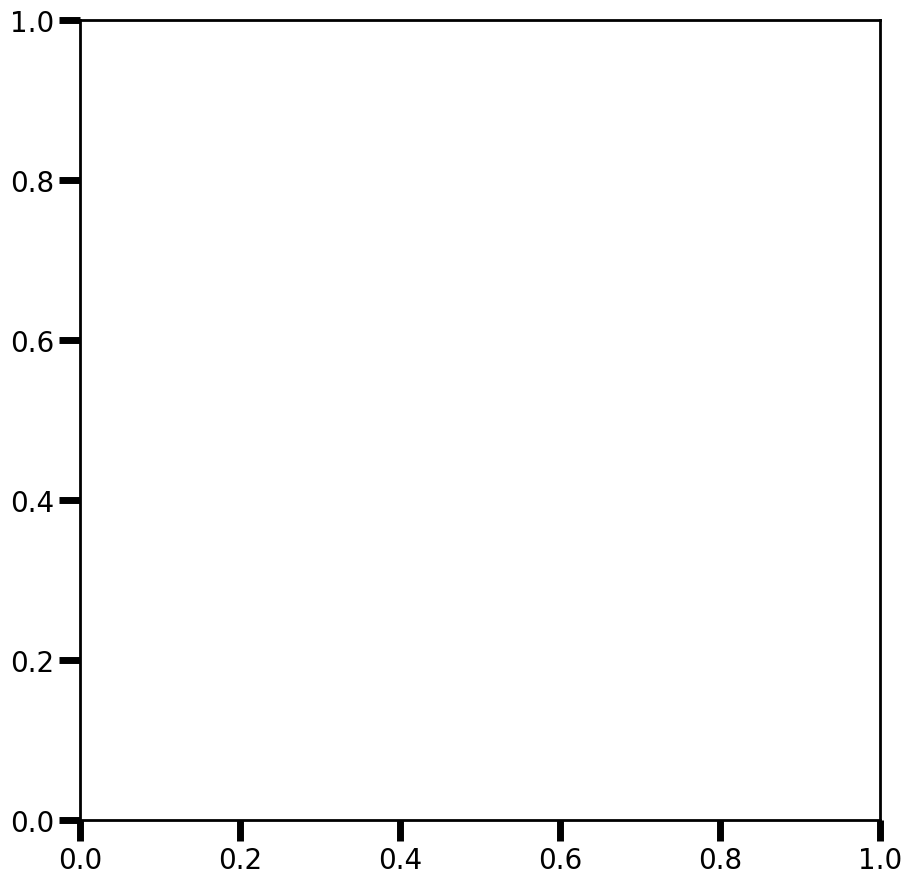

In [17]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2
ffsize=20;
dem_file=data_dir + 'demGeo.h5'
!ls -l {dem_file}
dem, atr_dem = readfile.read(dem_file)
#dem, atr_dem = readfile.read(dem_file, epoch='height')

geo_box=[1,2,3,4]; 
geo_box[0]=float(atr_dem['X_FIRST']);geo_box[1]=float(atr_dem['Y_FIRST']);
geo_box[2]=geo_box[0]+int(atr_dem['WIDTH'])*float(atr_dem['X_STEP']);
geo_box[3]=geo_box[1]+int(atr_dem['FILE_LENGTH'])*float(atr_dem['Y_STEP']);
#print geo_box
map_projection='cyl';
ls = LightSource(azdeg=315, altdeg=45)
dem_shade = ls.shade(dem, vert_exag=1.0, cmap=plt.cm.gray, vmin=-20000, vmax=np.nanmax(dem)+2500)
#bmap.imshow(dem_shade, origin='upper', interpolation='spline16')
lines_data=sio.loadmat(data_dir + 'hawaii_lines_new.mat',squeeze_me=True)

inf=open(data_dir + 'GPS_BenBrooks_03-05full.txt');next(inf)
# reader=csv.reader(inf, delimiter=' ');zipper=zip(*reader);
# gpslist= list(zipper[0])
# latlist = list(zipper[1]);lonlist = list(zipper[2])
gpslist=['PAT3','ALAL','PHAN','SLPC','MLSP','MOKP','MLES'];
latlist = [19.43044,19.38149,19.44696,19.40679,19.45118,19.48535,19.46432];
lonlist = [-155.57171,-155.59153,-155.63838,-155.67016,-155.59243,-155.59937,-155.55254];
fig = plt.figure(figsize=(10,10))
# plt.ylabel('Latitude')
# plt.xlabel('Longitude')
#plt.ylim((19.1,19.95));plt.xlim((-155.90,-155.35))
ax = fig.add_axes([0.1,0.1,0.8,0.8]); #fig.add_subplot(111);#
ax.tick_params(labelsize=ffsize);
#ax.xaxis.label.set_fontsize(40)
ax.tick_params(axis='x',length=15, width=5); 
ax.tick_params(axis='y',length=15, width=5); 
m = view.Basemap2(llcrnrlon=geo_box[0], llcrnrlat=geo_box[3],\
            urcrnrlon=geo_box[2], urcrnrlat=geo_box[1],\
            projection= map_projection,\
            resolution='c', area_thresh=1., suppress_ticks=False, ax=ax)
m.imshow(dem_shade, origin='upper', interpolation='spline16')#,zorder=0
plt.plot(lines_data['Lllh'][:,0],lines_data['Lllh'][:,1],color='black', linestyle='dashed',linewidth=3) #,zorder=1
plt.rc('xtick', labelsize=ffsize);plt.rc('ytick', labelsize=ffsize)
time1='2021-8-15';time2='2022-11-28'; 
time_y1=int(dt.strptime(time1,"%Y-%m-%d").strftime("%Y"));time_y2=int(dt.strptime(time2,"%Y-%m-%d").strftime("%Y"));
#time_list=np.arange(time_y1,time_y2,1)
#time_list=[2023,2023.1,2023.2,2023.3,2023.4]#range(time1,time2,1)
for i in range(len(gpslist)):
    dataval1=read_data(gpslist[i],time1,time2);
    #del dataval1
    #dataval1=read_data('MLES',2013,2017)
    #dataval_ref=read_data('MKEA',2013,2017)
    t=0.1; lon_0=lonlist[i];lat_0=latlist[i]; #print lon_0,lat_0
    #lon_0=-155.55254;lat_0=19.46432;
    dataval1['xpos']=float(lon_0)+(dataval1['east'])/105*t
    dataval1['ypos']=float(lat_0)+(dataval1['north'])/111*t
    #print dataval1
    n=0.005 #,zorder=10#
    #t1=np.min(dataval1['dateval']);t2=np.max(dataval1['dateval']);
    t1= 2022.9076;t2=2023.4223;
    img1=plt.scatter(dataval1['xpos'],dataval1['ypos'],c=dataval1['dateval'],s=4,cmap=newcmp,vmin= t1,vmax=t2)
    #del dataval1 #,zorder=11
    plt.plot(float(lon_0),float(lat_0),'D',markersize=15,markerfacecolor='none', markeredgecolor='black',markeredgewidth=3)
    #,zorder=12
    plt.text(float(lon_0)+0.01,float(lat_0),gpslist[i],fontsize=ffsize)
    


plt.ylim((19.18,19.68));plt.xlim((-155.82,-155.32));

bg_axes= fig.add_axes([0.17, 0.11, 0.65, 0.11]);
[bg_axes.spines[k].set_visible(False) for k in bg_axes.spines]
bg_axes.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
bg_axes.set_facecolor([1,1,1,0.5]);
time_list=np.linspace(2022.9158,2023.4114,7)
tick_labels=['D','23-J','F','M','A','M','Ju'];
cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.05])
cbar_ax.tick_params(labelsize=ffsize);
cbr=plt.colorbar(img1,cbar_ax,orientation='horizontal',ticks=time_list);#
cbr.set_label('date', size=ffsize, rotation=0,labelpad=-55)
cbr.set_ticklabels(tick_labels)
mark1='2022-12-06'
def date_to_colorbar_mark(mark,time_list):
    #print mark
    pt=(float(dt.strptime(mark,"%Y-%m-%d").strftime("%j"))-1) / 366 + float(dt.strptime(mark,"%Y-%m-%d").strftime("%Y"))
    cbar_mark=(pt-t1)/(t2-t1);
    return cbar_mark
cbar_mark1=date_to_colorbar_mark(mark1,time_list);
cbr.ax.axvline(cbar_mark1,color='r',linestyle='--',linewidth=3)

#fig.savefig("gps_ML_topo_motion_28nov2022_4Jun2023.pdf", dpi=300,bbox_inches='tight')
#fig.savefig("/Users/bkv3/Desktop/ML_GPS_2010_2017.pdf", dpi=300,bbox_inches='tight')

In [ ]:
top = cm.get_cmap('Blues', 128)
middle=cm.get_cmap('Greens', 128)
bottom = cm.get_cmap('Reds', 128)
newcolors = np.vstack((top(np.linspace(0.25, 0.75, 8)),
                       
                       bottom(np.linspace(0.25, 0.75, 182)),))
newcmp = ListedColormap(newcolors, name='OrangeGreysBlue')


In [7]:
dem_file
!ls -l {dem_file}
# dem, atr_dem = readfile.read(dem_file)
!pwd

-rw-r--r--@ 1 famelung  staff  7101750 Jul 10 18:27 /Users/famelung/onedrive/scratch/MaunaLoa/try/data/demGeo.h5
/Users/famelung/onedrive/scratch/MaunaLoa/try


In [ ]:
fig = plt.figure(figsize=(10,10))
# plt.ylabel('Latitude')
# plt.xlabel('Longitude')
#plt.ylim((19.1,19.95));plt.xlim((-155.90,-155.35))
ax = fig.add_axes([0.1,0.1,0.8,0.8]); #fig.add_subplot(111);#
ax.tick_params(labelsize=ffsize);
#ax.xaxis.label.set_fontsize(40)
ax.tick_params(axis='x',length=15, width=5); 
ax.tick_params(axis='y',length=15, width=5); 
m = view.Basemap2(llcrnrlon=geo_box[0], llcrnrlat=geo_box[3],\
            urcrnrlon=geo_box[2], urcrnrlat=geo_box[1],\
            projection= map_projection,\
            resolution='c', area_thresh=1., suppress_ticks=False, ax=ax)
m.imshow(dem_shade, origin='upper', interpolation='spline16')#,zorder=0
plt.plot(lines_data['Lllh'][:,0],lines_data['Lllh'][:,1],color='black', linestyle='dashed',linewidth=3) #,zorder=1
plt.rc('xtick', labelsize=ffsize);plt.rc('ytick', labelsize=ffsize)
time1='2021-8-15';time2='2022-11-27'; 
time_y1=int(dt.strptime(time1,"%Y-%m-%d").strftime("%Y"));time_y2=int(dt.strptime(time2,"%Y-%m-%d").strftime("%Y"));
#time_list=np.arange(time_y1,time_y2,1)
#time_list=[2023,2023.1,2023.2,2023.3,2023.4]#range(time1,time2,1)
plot_list=['PAT3','ALAL','PHAN','SLPC','AINP','TOUO','MLES','ALEP','STEP','PUKA','MLRD','MOKP','MLSP'];
for i in range(len(gpslist)):
    if gpslist[i] in plot_list:
        dataval1=read_data(gpslist[i],time1,time2);
        #del dataval1
        #dataval1=read_data('MLES',2013,2017)
        #dataval_ref=read_data('MKEA',2013,2017)
        t=0.09; lon_0=lonlist[i];lat_0=latlist[i]; #print lon_0,lat_0
        #lon_0=-155.55254;lat_0=19.46432;
        dataval1['xpos']=float(lon_0)+(dataval1['east'])/105*t
        dataval1['ypos']=float(lat_0)+(dataval1['north'])/111*t
        #print dataval1
        n=0.005 #,zorder=10#
        #t1=np.min(dataval1['dateval']);t2=np.max(dataval1['dateval']);
        t1= 2022.9322;t2=2023.4223;
        img1=plt.scatter(dataval1['xpos'],dataval1['ypos'],c='blue',s=4,vmin= t1,vmax=t2)
        #del dataval1 #,zorder=11
        plt.plot(float(lon_0),float(lat_0),'D',markersize=15,markerfacecolor='none', markeredgecolor='black',markeredgewidth=3)
        #,zorder=12
        plt.text(float(lon_0)+0.01,float(lat_0),gpslist[i],fontsize=ffsize)
    

ax.set_title('15Aug2021-27Nov2022',fontsize=20)
plt.ylim((19.3,19.6));plt.xlim((-155.78,-155.4));
plt.xticks(np.linspace(-155.75,-155.45,4));plt.yticks(np.linspace(19.3,19.6,4));
fig.savefig("gps_ML_topo_motion_15Aug2021-27Nov2022", dpi=300,bbox_inches='tight');

In [ ]:
fig = plt.figure(figsize=(10,10))
# plt.ylabel('Latitude')
# plt.xlabel('Longitude')
#plt.ylim((19.1,19.95));plt.xlim((-155.90,-155.35))
ax = fig.add_axes([0.1,0.1,0.8,0.8]); #fig.add_subplot(111);#
ax.tick_params(labelsize=ffsize);
#ax.xaxis.label.set_fontsize(40)
ax.tick_params(axis='x',length=15, width=5); 
ax.tick_params(axis='y',length=15, width=5); 
m = view.Basemap2(llcrnrlon=geo_box[0], llcrnrlat=geo_box[3],\
            urcrnrlon=geo_box[2], urcrnrlat=geo_box[1],\
            projection= map_projection,\
            resolution='c', area_thresh=1., suppress_ticks=False, ax=ax)
m.imshow(dem_shade, origin='upper', interpolation='spline16')#,zorder=0
plt.plot(lines_data['Lllh'][:,0],lines_data['Lllh'][:,1],color='black', linestyle='dashed',linewidth=3) #,zorder=1
plt.rc('xtick', labelsize=ffsize);plt.rc('ytick', labelsize=ffsize)
time1='2022-11-28';time2='2022-12-06'; 
time_y1=int(dt.strptime(time1,"%Y-%m-%d").strftime("%Y"));time_y2=int(dt.strptime(time2,"%Y-%m-%d").strftime("%Y"));
#time_list=np.arange(time_y1,time_y2,1)
#time_list=[2023,2023.1,2023.2,2023.3,2023.4]#range(time1,time2,1)
plot_list=['PAT3','ALAL','PHAN','SLPC','AINP','TOUO','MLES','ALEP','STEP','PUKA','MOKP','MLSP'];
for i in range(len(gpslist)):
    if gpslist[i] in plot_list:
        #print gpslist[i]
        dataval1=read_data(gpslist[i],time1,time2);
        #del dataval1
        #dataval1=read_data('MLES',2013,2017)
        #dataval_ref=read_data('MKEA',2013,2017)
        t=0.09; lon_0=lonlist[i];lat_0=latlist[i]; #print lon_0,lat_0
        #lon_0=-155.55254;lat_0=19.46432;
        dataval1['xpos']=float(lon_0)+(dataval1['east'])/105*t
        dataval1['ypos']=float(lat_0)+(dataval1['north'])/111*t
        #print dataval1
        n=0.005 #,zorder=10#
        #t1=np.min(dataval1['dateval']);t2=np.max(dataval1['dateval']);
        t1= 2022.9322;t2=2023.4223;
        img1=plt.scatter(dataval1['xpos'],dataval1['ypos'],s=4,label=gpslist[i])
        #del dataval1 #,zorder=11
        plt.plot(float(lon_0),float(lat_0),'D',markersize=15,markerfacecolor='none', markeredgecolor='black',markeredgewidth=3)
        #,zorder=12
        plt.text(float(lon_0)+0.01,float(lat_0),gpslist[i],fontsize=ffsize)
    
ax.legend()
ax.set_title('28Nov2022-06Dec2022',fontsize=20)
plt.ylim((19.3,19.6));plt.xlim((-155.78,-155.4));
plt.xticks(np.linspace(-155.75,-155.45,4));plt.yticks(np.linspace(19.3,19.6,4));
fig.savefig("gps_ML_topo_motion_28Nov2022-06Dec2022", dpi=300,bbox_inches='tight');

In [ ]:
fig = plt.figure(figsize=(10,10))
# plt.ylabel('Latitude')
# plt.xlabel('Longitude')
#plt.ylim((19.1,19.95));plt.xlim((-155.90,-155.35))
ax = fig.add_axes([0.1,0.1,0.8,0.8]); #fig.add_subplot(111);#
ax.tick_params(labelsize=ffsize);
#ax.xaxis.label.set_fontsize(40)
ax.tick_params(axis='x',length=15, width=5); 
ax.tick_params(axis='y',length=15, width=5); 
m = view.Basemap2(llcrnrlon=geo_box[0], llcrnrlat=geo_box[3],\
            urcrnrlon=geo_box[2], urcrnrlat=geo_box[1],\
            projection= map_projection,\
            resolution='c', area_thresh=1., suppress_ticks=False, ax=ax)
m.imshow(dem_shade, origin='upper', interpolation='spline16')#,zorder=0
plt.plot(lines_data['Lllh'][:,0],lines_data['Lllh'][:,1],color='black', linestyle='dashed',linewidth=3) #,zorder=1
plt.rc('xtick', labelsize=ffsize);plt.rc('ytick', labelsize=ffsize)
time1='2022-12-07';time2='2023-6-04'; 
time_y1=int(dt.strptime(time1,"%Y-%m-%d").strftime("%Y"));time_y2=int(dt.strptime(time2,"%Y-%m-%d").strftime("%Y"));
#time_list=np.arange(time_y1,time_y2,1)
#time_list=[2023,2023.1,2023.2,2023.3,2023.4]#range(time1,time2,1)
plot_list=['ALAL','PHAN','SLPC','AINP','TOUO','MLES','ALEP','STEP','PUKA','MOKP','MLSP'];
for i in range(len(gpslist)):
    if gpslist[i] in plot_list:
        #print gpslist[i]
        dataval1=read_data(gpslist[i],time1,time2);
        #del dataval1
        #dataval1=read_data('MLES',2013,2017)
        #dataval_ref=read_data('MKEA',2013,2017)
        t=0.09; lon_0=lonlist[i];lat_0=latlist[i]; #print lon_0,lat_0
        #lon_0=-155.55254;lat_0=19.46432;
        dataval1['xpos']=float(lon_0)+(dataval1['east'])/105*t
        dataval1['ypos']=float(lat_0)+(dataval1['north'])/111*t
        #print dataval1
        n=0.005 #,zorder=10#
        #t1=np.min(dataval1['dateval']);t2=np.max(dataval1['dateval']);
        t1= 2022.9322;t2=2023.4223;
        img1=plt.scatter(dataval1['xpos'],dataval1['ypos'],c='blue',s=4,vmin= t1,vmax=t2)
        #del dataval1 #,zorder=11
        plt.plot(float(lon_0),float(lat_0),'D',markersize=15,markerfacecolor='none', markeredgecolor='black',markeredgewidth=3)
        #,zorder=12
        plt.text(float(lon_0)+0.01,float(lat_0),gpslist[i],fontsize=ffsize)
    

ax.set_title('07Dec2022-04Jun2023',fontsize=20)
plt.ylim((19.3,19.6));plt.xlim((-155.78,-155.4));
plt.xticks(np.linspace(-155.75,-155.45,4));plt.yticks(np.linspace(19.3,19.6,4));
fig.savefig("gps_ML_topo_motion_07Dec2022-04Jun2023", dpi=300,bbox_inches='tight');